# Анализ оттока клиентов банка

Задача:
Проанализируйте клиентов регионального банка и выделите сегменты клиентов,
которые склонны уходить из банка.
Проведите исследовательский анализ данных, определите все значимые
признаки отточности (интервалы значений характеристик, которые связаны с
повышенным оттоком, сравните портреты типичных клиентов, которые
склонны и не склонны уходить из банка и т.д)
Сформулируйте и проверьте статистические гипотезы.
Проверьте гипотезу различия дохода между теми клиентами, которые
ушли и теми, которые остались.
Сформулируйте и проверьте статистическую гипотезу относительно
представленных данных, которая поможет внести ясность в исследование
Объединяя признаки отточности, сформируйте сегменты, отберите из них
лучшие и дайте по ним рекомендации

### Описание данных

User_id – идентификатор пользователя;

Score – баллы кредитного скоринга;

City – город;

Genger – пол;

Age – возраст;

Balance – баланс на счёте;

Products– количество продуктов, которыми пользуется клиент;

CreditCart – имеется ли кредитная карта;

Last_activity – активный клиент;

Еstimated_salary – заработная плата клиента;

Churn – ушёл или нет;

Equity – кол-во баллов собственности;

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from scipy import stats as st
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import json
from folium.plugins import MarkerCluster
import folium
import phik

# Загружаем необходимые библиотеки

##  шаг. Загрузим данные и изучим общую информацию

In [3]:
data = pd.read_csv('/datasets/bank_scrooge.csv')

In [4]:
data.head(5)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [5]:
data.info()
# смотрим информацию

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [6]:
data.duplicated().sum()
# проверяем наличие дубликатов

0

In [7]:
data.isna().sum()
# проверяем наличие пропусков

USERID              0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
EST_SALARY          0
churn               0
dtype: int64

Вывод. В таблице данные по 10000 клиентам банка. Явных дубликатов нет, пропуски в графе "возраст" - всего 26, в графе "баланс" - там 23% пропущенных данных, далее будем думать, что с ними делать

## шаг. Выполним предобработку даных

In [8]:
data = data.rename(columns = {'USERID': 'user_id', 'EST_SALARY': 'est_salary'})
data.head(2)
# переименовываем столбцы, проверяем

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0


In [9]:
data.duplicated(subset = ['user_id']).sum()
# считаем дубликаты по категории user_id

73

In [10]:
data.duplicated(subset = ['score','city','gender','age','equity','balance','products','credit_card','last_activity','est_salary','churn' ]).sum()
# считаем дубликаты без user_id

0

In [11]:
data_dubl = data.loc[data.duplicated(subset =['user_id'], keep = False)]
data_dubl
# выводим дубликаты по категориям

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
58,164676,860.0,Ярославль,М,37.0,5,648594.03,2,1,1,213586.86,1
150,185748,850.0,Рыбинск,М,36.0,5,1203376.67,2,0,1,89401.82,1
161,197364,928.0,Рыбинск,Ж,53.0,6,1347183.86,2,0,1,168189.49,1
231,190253,823.0,Рыбинск,М,37.0,4,373348.39,2,0,1,131947.92,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0
9785,168998,895.0,Рыбинск,М,44.0,0,282653.53,3,0,0,255296.47,0
9819,140934,832.0,Рыбинск,Ж,NaN,3,385763.16,2,0,1,59651.35,0
9880,217412,886.0,Ярославль,Ж,35.0,3,1026172.14,2,1,0,53099.16,0


In [12]:
data_dubl.groupby('city')['city'].count()
# посмотрим в каких городах дубликаты

city
Рыбинск      73
Ярославль    73
Name: city, dtype: int64

Дубликаты распределены поровну по городам, В Ростове дубликатов нет. Клиенты с одинаковым id не являются одними и теми же людьми, так как у них разные пол и возраст.  Дубликаты образовались скорее всего из-за того, что отделения в городах Рыбинск и Ярославль были не подключены к общей системе. Такие дубликаты удалять не будем.

In [13]:
data_isna_a = data[data['age'].isnull() == True ] 
data_isna_a.head(26)
# смотрим у кого пропуски в возрасте

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1247,228075,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0
2165,187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0
2444,221156,913.0,Ярославль,М,NaN,0,NaN,1,1,1,135693.24,0
3091,138660,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1
4912,210674,834.0,Рыбинск,М,NaN,1,238330.52,2,0,1,93775.06,0
5470,218868,827.0,Рыбинск,Ж,NaN,4,448959.07,2,1,1,67835.95,0
5495,151662,884.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,137500.77,0
7236,210135,908.0,Рыбинск,Ж,NaN,4,1120340.31,3,1,1,85002.15,0
7248,219343,920.0,Рыбинск,Ж,NaN,0,NaN,1,1,0,159248.67,0
7345,184913,829.0,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0


Возраст пропущен у 26 человек, все они из Ярославля и Рыбинска, являются клиентами банка. Кроме одной женщины из Ростова, которая ушла. 

In [14]:
data_isna_b = data[data['balance'].isnull() == True ] 
data_isna_b.head(10)
# посмотрим у кого пропуски в балансе

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0
10,148929,927.0,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0
11,172184,921.0,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0
19,127034,922.0,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0
21,177415,896.0,Рыбинск,Ж,47.0,0,NaN,1,0,0,225060.35,0
30,155730,946.0,Ярославль,Ж,47.0,0,NaN,2,1,1,660015.85,0
34,205226,944.0,Ярославль,М,35.0,0,NaN,2,1,1,239843.39,0
39,173175,924.0,Рыбинск,Ж,51.0,0,NaN,1,1,1,248844.47,0
43,228585,956.0,Ростов,М,41.0,0,NaN,1,1,0,115117.10,0


In [15]:
data_isna_b.groupby('city')['city'].count()
# посмотрим пропуски по городам

city
Ростов        235
Рыбинск       593
Ярославль    1467
Name: city, dtype: int64

In [16]:
data_isna_b.groupby('last_activity')['last_activity'].count()
# посмотрим пропуски по активности

last_activity
0    1034
1    1261
Name: last_activity, dtype: int64

In [17]:
data_isna_b.groupby('credit_card')['credit_card'].count()
# посмотрим пропуски по наличию кредитной карты

credit_card
0     423
1    1872
Name: credit_card, dtype: int64

In [18]:
data_isna_b.groupby('products')['products'].count()
# посмотрим пропуски по количеству продуктов

products
0       1
1    1950
2     315
3      29
Name: products, dtype: int64

In [19]:
data_isna_b.groupby('churn')['churn'].count()
# а вообще клиенты может уже ушли?

churn
0    2282
1      13
Name: churn, dtype: int64

In [20]:
data.groupby('city')['city'].count()
# посмотрим как распределены клиенты по городам

city
Ростов       1417
Рыбинск      2695
Ярославль    5888
Name: city, dtype: int64

In [21]:
data.describe().applymap('{:,.2f}'.format)
# посмотрим на аномалии

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,"10,000.00","10,000.00","9,974.00","10,000.00","7,705.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,"171,814.71",848.70,42.73,2.63,"827,794.31",1.87,0.68,0.52,"147,866.89",0.18
std,"33,708.24",65.45,12.18,1.98,"1,980,614.15",0.79,0.47,0.50,"139,388.51",0.39
min,"94,561.00",642.00,18.00,0.00,0.00,0.00,0.00,0.00,"2,546.30",0.00
25%,"142,810.25",802.00,33.00,0.00,"295,554.16",1.00,0.00,0.00,"75,251.90",0.00
50%,"172,728.00",853.00,40.00,3.00,"524,272.20",2.00,1.00,1.00,"119,658.10",0.00
75%,"201,261.75",900.00,51.00,4.00,"980,705.85",2.00,1.00,1.00,"174,500.54",0.00
max,"229,145.00","1,000.00",86.00,9.00,"119,113,552.01",5.00,1.00,1.00,"1,395,064.45",1.00


Странное значение клиента с 0 продуктов банка

In [22]:
data[data['products']==0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1


In [23]:
data = data[data['products']!=0]
# удалим странное значение, тем более, что это уже не клиент банка

In [24]:
data.describe().applymap('{:,.2f}'.format)
# проверим что получилось

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,"9,999.00","9,999.00","9,973.00","9,999.00","7,705.00","9,999.00","9,999.00","9,999.00","9,999.00","9,999.00"
mean,"171,817.11",848.69,42.73,2.63,"827,794.31",1.87,0.68,0.52,"147,879.17",0.18
std,"33,709.07",65.44,12.18,1.98,"1,980,614.15",0.79,0.47,0.50,"139,390.07",0.39
min,"94,561.00",642.00,18.00,0.00,0.00,1.00,0.00,0.00,"2,546.30",0.00
25%,"142,809.50",802.00,33.00,0.00,"295,554.16",1.00,0.00,0.00,"75,252.12",0.00
50%,"172,740.00",853.00,40.00,3.00,"524,272.20",2.00,1.00,1.00,"119,661.51",0.00
75%,"201,262.50",900.00,51.00,4.00,"980,705.85",2.00,1.00,1.00,"174,501.12",0.00
max,"229,145.00","1,000.00",86.00,9.00,"119,113,552.01",5.00,1.00,1.00,"1,395,064.45",1.00


Аномальных значений в данных больше нет, все в пределах реального

In [25]:
data['city_2'] = data['city']
data['gender_2'] = data['gender']
data.head(2)
# создадим копии категориальных столбцов

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_2,gender_2
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,Рыбинск,Ж
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,Рыбинск,Ж


In [26]:
data = pd.get_dummies (data, columns=['gender_2', 'city_2'] )
data.head(2)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_2_Ж,gender_2_М,city_2_Ростов,city_2_Рыбинск,city_2_Ярославль
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,1,0,0,1,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,1,0,0,1,0


In [27]:
data = data.rename (
    columns = ({'city_2_Ростов':'Ростов', 'city_2_Рыбинск':'Рыбинск','city_2_Ярославль':'Ярославль',
                'gender_2_Ж':'woman', 'gender_2_М':'man'}))

In [28]:
data.head(2)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,woman,man,Ростов,Рыбинск,Ярославль
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,1,0,0,1,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,1,0,0,1,0


Удалили клиента, у которого нет банковских продуктов. Пропуски в балансе удалять не стали, дубликаты по user_idоставлил, так как это е влияет на исследование, и это разные клиенты. Создали и добавили копии категориальных столбцов.

Пропуски в графе "возраст" относятся к MСAR, пропуски не зависят от переменных и не ведут к систематической ошибке, но увеличивают случайную ошибку, можно их отбрасывать;

Пропуски в графе "баланс" относятся к MNAR, их нельзя отбрасывать, так как это приведет к сильным искажениям

## шаг. Исследовательский анализ данных EDA

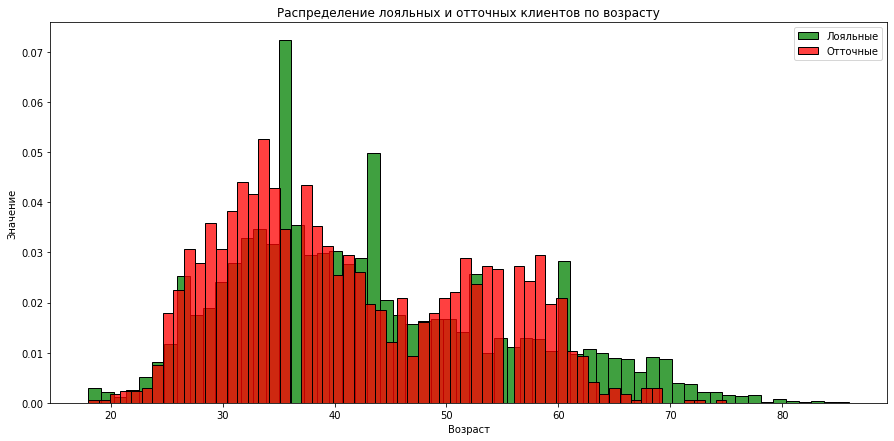

In [29]:
plt.figure(figsize=(15,7))
sns.histplot(data[data['churn'] == 0]['age'], stat='density',  common_norm=False, bins = 60, color='Green');
sns.histplot(data[data['churn'] == 1]['age'],   stat='density', common_norm=False, bins = 60, color='Red');
plt.legend(['Лояльные', 'Отточные']);
plt.title('Распределение лояльных и отточных клиентов по возрасту')
plt.xlabel('Возраст');
plt.ylabel('Значение');
plt.show();

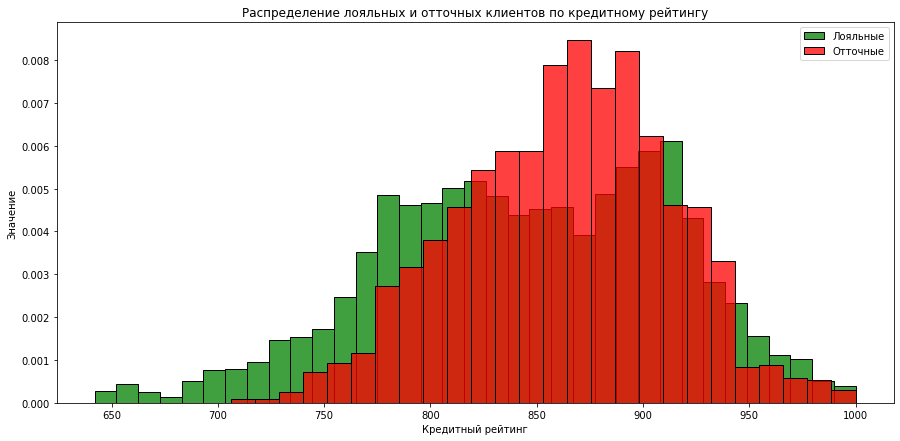

In [30]:
plt.figure(figsize=(15,7))

sns.histplot(data[data['churn'] == 0]['score'],  stat='density',  common_norm=False,  color='Green');
sns.histplot(data[data['churn'] == 1]['score'],   stat='density', common_norm=False, color='Red');
plt.legend(['Лояльные', 'Отточные']);
plt.title('Распределение лояльных и отточных клиентов по кредитному рейтингу')
plt.xlabel('Кредитный рейтинг');
plt.ylabel('Значение');
plt.show();

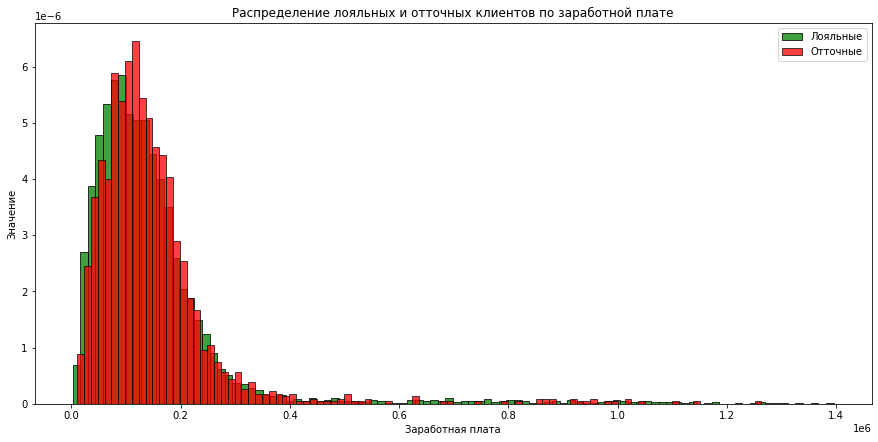

In [31]:
plt.figure(figsize=(15,7))
sns.histplot(data[data['churn'] == 0]['est_salary'],  stat='density',  common_norm=False, bins = 100, color='Green');
sns.histplot(data[data['churn'] == 1]['est_salary'],   stat='density', common_norm=False, bins = 100, color='Red');
plt.legend(['Лояльные', 'Отточные']);
plt.title('Распределение лояльных и отточных клиентов по заработной плате')
plt.xlabel('Заработная плата');
plt.ylabel('Значение');
plt.show();

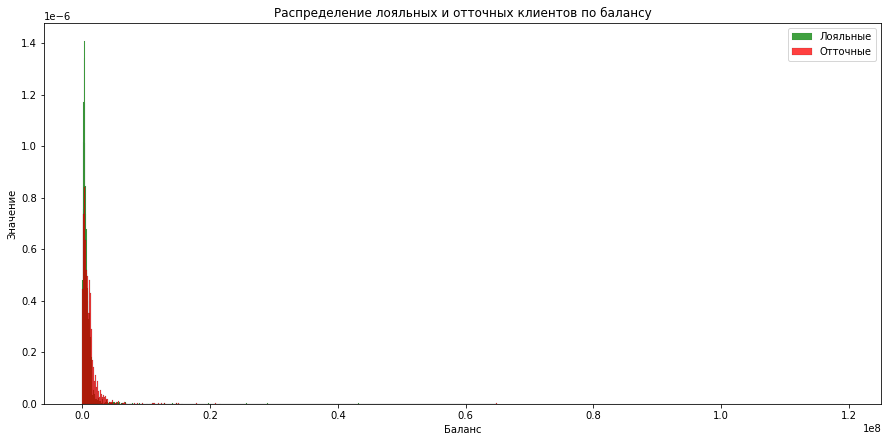

In [32]:
plt.figure(figsize=(15,7))
sns.histplot(data[data['churn'] == 0]['balance'],  stat='density',  common_norm=False,  color='Green');
sns.histplot(data[data['churn'] == 1]['balance'],   stat='density',  common_norm=False, color='Red');
plt.legend(['Лояльные', 'Отточные']);
plt.title('Распределение лояльных и отточных клиентов по балансу')
plt.xlabel('Баланс');
plt.ylabel('Значение');
plt.show();

Категории оттока:

Клиенты  в возрасте 25-30 лет и 50-60

Клиенты с кредитным рейтингом 830-940

Клиенты с заработной платой свыше 100 тыс.

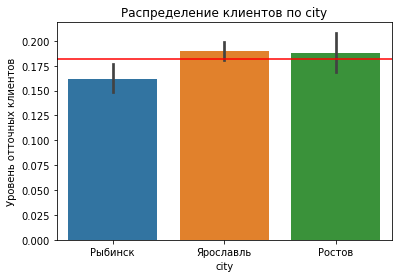

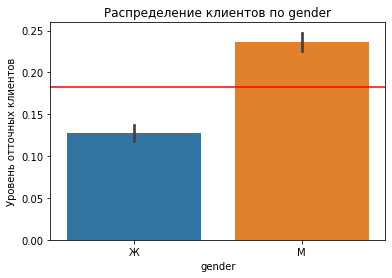

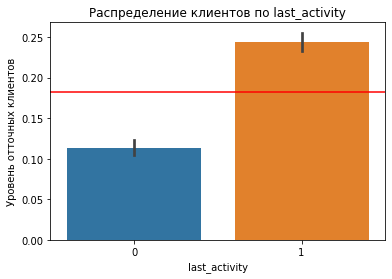

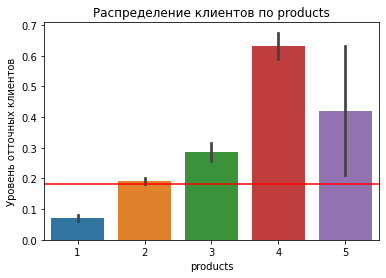

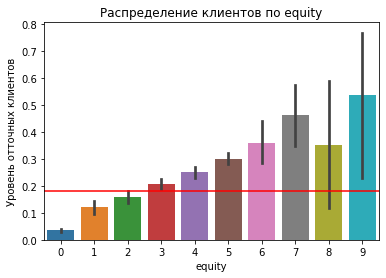

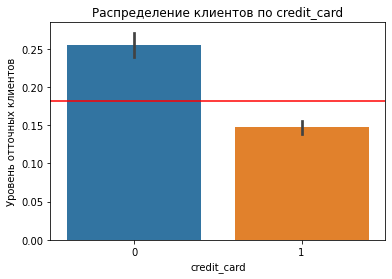

In [33]:
churn_mean=data['churn'].mean()
for column in data[['city', 'gender', 'last_activity', 'products', 'equity', 'credit_card']].columns:
    ax = sns.barplot(x=column, y='churn', data=data)
    plt.title('Распределение клиентов по ' + column)
    plt.ylabel('Уровень отточных клиентов')
    plt.axhline(y=churn_mean, color='red', alpha=1)
    plt.show()

Категории оттока:

Мужчины менее лояльны, чем женщины

Активные пользователи банковскими продуктами менее лояльны

Клиенты с более 3 объектами имущества менее лояльны

Определим возрастные категории
до 24 лет
25 -  45 лет
46 - 62 года
старше 63 лет

In [34]:
def age_cat(age):
    if 18 <= age <= 24:
        return '18-24'
    if 25 <= age <= 45:
        return '25-45'
    if 46 <= age <= 62:
        return '46-62'
    if 63 <= age:
        return '63+'
# разделим клиентов по возрастным категориям

In [35]:
data['age_cat'] = data['age'].apply (age_cat)
data.head(2)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,woman,man,Ростов,Рыбинск,Ярославль,age_cat
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,1,0,0,1,0,25-45
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,1,0,0,1,0,25-45


In [36]:
pd.set_option('display.max_columns', None) 

In [37]:
data['age_cat_2'] = data['age_cat']
data = pd.get_dummies (data, columns=['age_cat_2'] )
data = data.rename (
    columns = ({'age_cat_2_18-24':'18-24', 'age_cat_2_25-45':'25-45','age_cat_2_46-62':'46-62',
                'age_cat_2_63+':'63+'}))
data.head(2)
# добавялем копии возрастных категорий

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,woman,man,Ростов,Рыбинск,Ярославль,age_cat,18-24,25-45,46-62,63+
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,1,0,0,1,0,25-45,0,1,0,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,1,0,0,1,0,25-45,0,1,0,0


In [38]:
data_corr = data.drop(['user_id'], axis=1).corr()
data_corr.head(1)
# уберем user_id для тепловой карты

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,woman,man,Ростов,Рыбинск,Ярославль,18-24,25-45,46-62,63+
score,1.0,-0.012339,0.064103,0.235812,-0.003708,-0.094503,-0.031004,0.164049,0.105634,-0.012429,0.012429,-0.037572,-0.000609,0.02718,-0.007252,0.010853,-0.014162,0.007088


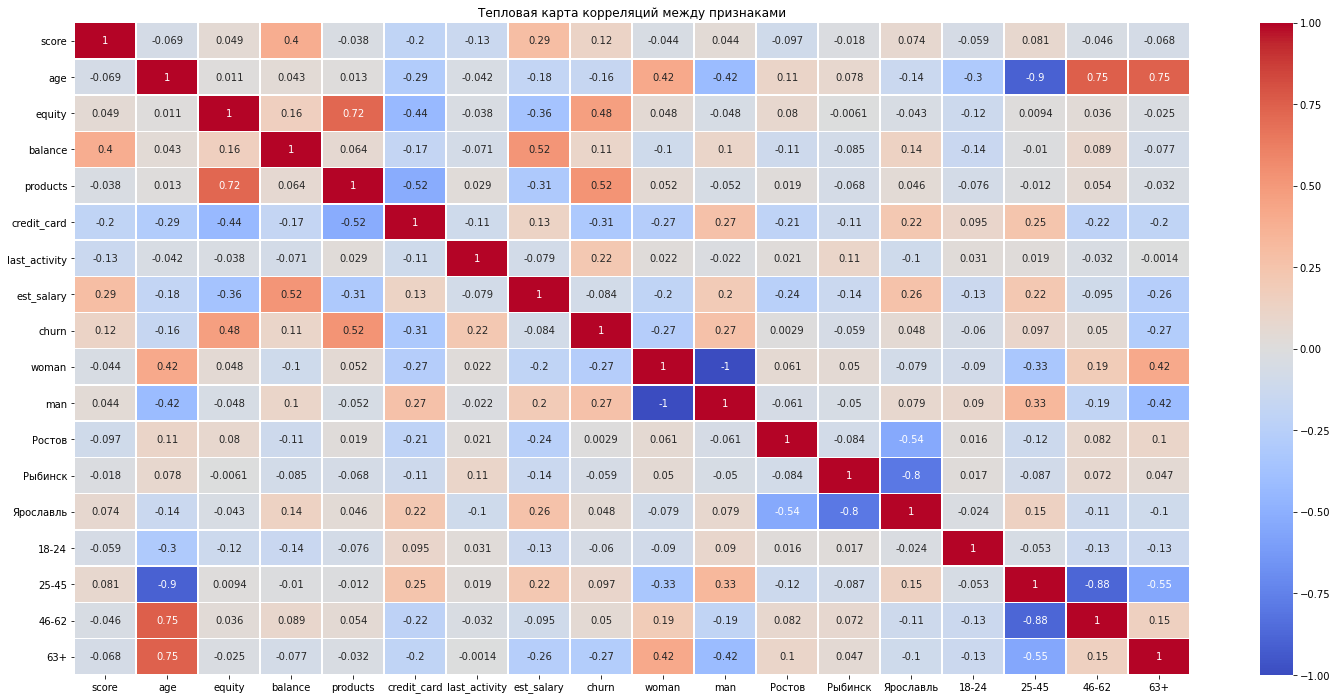

In [39]:
plt.figure(figsize=(25, 12))
sns.heatmap (data_corr.corr(), annot = True, vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm', linewidths = 0.5)
plt.title('Тепловая карта корреляций между признаками')
plt.show();

Тепловая карта говорит нам о наличии зависимости впервую очередь между наличием банковских продуктов и имуществом, кредитным рейтингом, заработной платой и  балансом

In [40]:
churns = data.groupby('churn').agg({
                                    'score' : 'median',
                                    'age': 'median',
                                    'Ростов': 'mean',
                                    'Рыбинск': 'mean',
                                    'Ярославль': 'mean',
                                    'balance': 'median',
                                    'products': 'mean',
                                    'equity': 'mean',
                                    'man': 'mean',
                                    'woman': 'mean',
                                    'est_salary': 'median',
                                    'last_activity': 'mean',
                                    '18-24': 'mean',
                                    '25-45': 'mean',
                                    '46-62': 'mean',
                                    '63+': 'mean'}
)

churns
# сравним отточных и не отточных 

,score,age,Ростов,Рыбинск,Ярославль,balance,products,equity,man,woman,est_salary,last_activity,18-24,25-45,46-62,63+
churn,,,,,,,,,,,,,,,,
0,848.0,40.0,0.140709,0.276039,0.583252,475382.445,1.757579,2.374817,0.467237,0.532763,118257.715,0.483741,0.025061,0.620049,0.260513,0.091320
1,866.0,39.0,0.146234,0.239692,0.614074,782410.470,2.377130,3.764156,0.650357,0.349643,125395.220,0.702584,0.017042,0.627817,0.336998,0.017592


In [41]:
pd.concat(
    {'Лояльные': churns.iloc[0],
    'Отточные': churns.iloc[1],
    'Разница': (churns.iloc[1]/churns.iloc[0]-1)*100},
        axis=1).sort_values('Разница', ascending = False)
# добавляем разницу и сортируем                                                                           

,Лояльные,Отточные,Разница
balance,475382.445000,782410.470000,64.585478
equity,2.374817,3.764156,58.503022
last_activity,0.483741,0.702584,45.239722
man,0.467237,0.650357,39.192125
products,1.757579,2.377130,35.250232
46-62,0.260513,0.336998,29.359292
est_salary,118257.715000,125395.220000,6.035551
Ярославль,0.583252,0.614074,5.284481
Ростов,0.140709,0.146234,3.926647
score,848.000000,866.000000,2.122642


In [42]:
d_a = data.pivot_table(columns='churn', values=['city', 'gender', 'last_activity', 'products', 'equity', 'credit_card'],\
                             aggfunc={'city': pd.Series.mode, 'gender' : pd.Series.mode,\
                                     'last_activity': pd.Series.mode,'products': pd.Series.mode,\
                                     'equity': pd.Series.mode, 'credit_card': pd.Series.mode}).reset_index()
d_a
# категориальные признаки

churn,index,0,1
0,city,Ярославль,Ярославль
1,credit_card,1,1
2,equity,0,5
3,gender,Ж,М
4,last_activity,0,1
5,products,2,2


In [43]:
d_b = data.pivot_table(columns='churn', values=['est_salary','balance', 'score', 'age'],\
                             aggfunc={
                                     'est_salary': pd.Series.median,'balance': pd.Series.median,\
                                      'score': pd.Series.median,'age': pd.Series.median}).reset_index()
d_b
# непрерывные признаки

churn,index,0,1
0,age,40.000,39.00
1,balance,475382.445,782410.47
2,est_salary,118257.715,125395.22
3,score,848.000,866.00


In [44]:
d_b['Разница'] = np.round(((d_b[1] /d_b[0]-1) * 100),1).astype(str) + '%'
d_b

churn,index,0,1,Разница
0,age,40.000,39.00,-2.5%
1,balance,475382.445,782410.47,64.6%
2,est_salary,118257.715,125395.22,6.0%
3,score,848.000,866.00,2.1%


In [45]:
a = pd.concat([d_a, d_b], ignore_index=True).sort_values('Разница', ascending = False)
a = a.fillna('-') 
a
# ставим пропуск и соединяем  

churn,index,0,1,Разница
7,balance,475382.445,782410.47,64.6%
8,est_salary,118257.715,125395.22,6.0%
9,score,848.0,866.0,2.1%
6,age,40.0,39.0,-2.5%
0,city,Ярославль,Ярославль,-
1,credit_card,1,1,-
2,equity,0,5,-
3,gender,Ж,М,-
4,last_activity,0,1,-
5,products,2,2,-


Вывод: Отточными клиентами являются клиенты с высоким рейтингом имущества, бОльшим балансом, активные мужчины, с 4-5 продуктами чуть старше среднего возраста, с высокой зарплатой

## шаг. Проверка статистических гипотез

H0: Доходы лояльных  и отточных клиентов равны

H1: Доходы лояльных  и отточных клиентов не равны

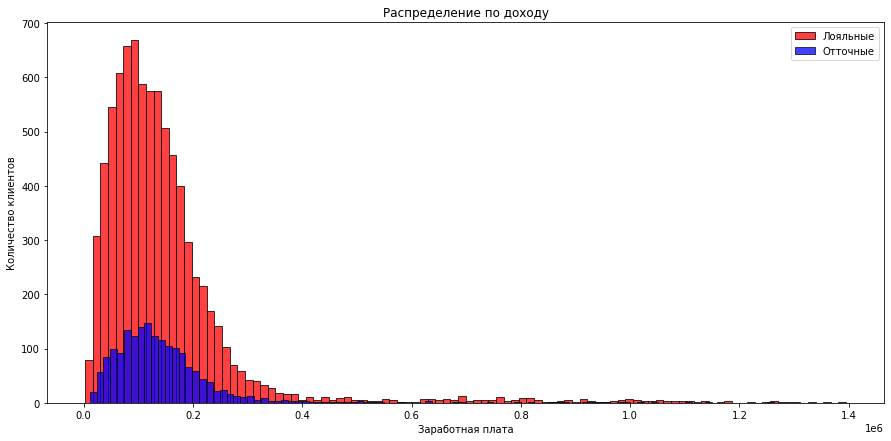

In [46]:
fig, scatter = plt.subplots(figsize = (15,7))
sns.histplot(data.query('churn == 0')['est_salary'], bins = 100, color='red' ) 
sns.histplot(data.query('churn == 1')['est_salary'], bins = 100, color = 'blue')
plt.title('Распределение по доходу')
plt.legend(['Лояльные', 'Отточные'])
plt.xlabel('Заработная плата')
plt.ylabel('Количество клиентов')

plt.show();

In [47]:
print ('Кол-во ушедших клиентов:', len(data.query('churn == 1')['est_salary']))
print('Кол-во лояльных клиентов:', len(data.query('churn == 0')['est_salary']))
print('Дисперсия отточных:', data.query('churn == 1')['est_salary'].var())
print('Дисперсия лояльных:', data.query('churn == 0')['est_salary'].var())

Кол-во ушедших клиентов: 1819
Кол-во лояльных клиентов: 8180
Дисперсия отточных: 15107935966.895876
Дисперсия лояльных: 20392519451.455894


In [48]:
alpha = 0.05  

shapiro_test_stat, p_value = st.shapiro(data.query('churn == 0')['est_salary'])
print('p-значение: ', p_value)
if p_value < alpha:
    print('Распределение не нормально')
else:
    print('Нормальное распределение')  
# проверим лояльных на распределение

p-значение:  0.0
Распределение не нормально


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [49]:
alpha = 0.05  

shapiro_test_stat, p_value = st.shapiro(data.query('churn == 1')['est_salary'])
print('p-значение: ', p_value)
if p_value < alpha:
    print('Распределение не нормально')
else:
    print('Нормальное распределение')  
# проверим отточных на распределение

p-значение:  0.0
Распределение не нормально


Выборки распределены не нормально, дисперсии не равны, соответсвенно тест Стьюдента не подходит - используем тест Манна Уитни

In [50]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu((data.query('churn == 0')['est_salary']), (data.query('churn == 1')['est_salary']))

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.00021160652203623057
Отвергаем нулевую гипотезу: разница статистически значима


H0: Кредитный рейтинг лояльных  и отточных клиентов равны

H1: Кредитный рейтинг лояльных  и отточных клиентов не равны

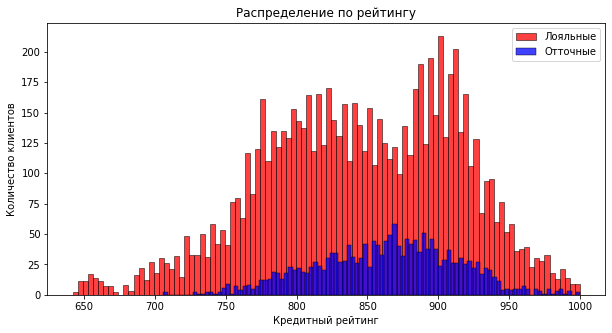

In [51]:
fig, scatter = plt.subplots(figsize = (10,5))
sns.histplot(data.query('churn == 0')['score'], bins = 100, color='red')
sns.histplot(data.query('churn == 1')['score'], bins = 100, color = 'blue')
plt.title('Распределение по рейтингу')
plt.legend(['Лояльные', 'Отточные'])
plt.xlabel('Кредитный рейтинг')
plt.ylabel('Количество клиентов')
plt.show();

In [52]:
print('Дисперсия отточных:', data.query('churn == 1')['score'].var())
print('Дисперсия лояльных:', data.query('churn == 0')['score'].var())

Дисперсия отточных: 2457.3047909518823
Дисперсия лояльных: 4630.492360930297


In [53]:
alpha = 0.05  

shapiro_test_stat, p_value = st.shapiro(data.query('churn == 0')['score'])
print('p-значение: ', p_value)
if p_value < alpha:
    print('Распределение не нормально')
else:
    print('Нормальное распределение')  
# проверим лояльных на распределение

p-значение:  3.817680641163025e-26
Распределение не нормально


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [54]:
alpha = 0.05  

shapiro_test_stat, p_value = st.shapiro(data.query('churn == 1')['score'])
print('p-значение: ', p_value)
if p_value < alpha:
    print('Распределение не нормально')
else:
    print('Нормальное распределение')  
# проверим отточных на распределение

p-значение:  0.00010231484338873997
Распределение не нормально


Выборки распределены не нормально, хвост слева, дисперсии не равны, соответсвенно тест Стьюдента не подходит - используем тест Манна Уитни

In [55]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu((data.query('churn == 0')['score']), (data.query('churn == 1')['score']))

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  7.364570509844462e-22
Отвергаем нулевую гипотезу: разница статистически значима


H0: Количество банковскийх продуктов у лояльных  и отточных клиентов равно

H1: Количество банковскийх продуктов  лояльных  и отточных клиентов не равно

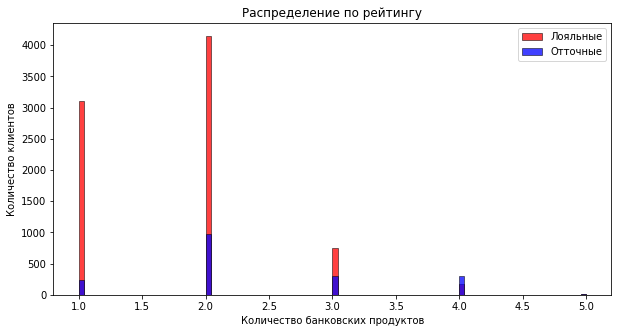

In [56]:
fig, scatter = plt.subplots(figsize = (10,5))
sns.histplot(data.query('churn == 0')['products'], bins = 100, color='red')
sns.histplot(data.query('churn == 1')['products'], bins = 100, color = 'blue')
plt.title('Распределение по рейтингу')
plt.legend(['Лояльные', 'Отточные'])
plt.xlabel('Количество банковских продуктов')
plt.ylabel('Количество клиентов')
plt.show();

In [57]:
print ('Кол-во ушедших:', len(data.query('churn == 1')['products']))
print('Кол-во лояльных:', len(data.query('churn == 0')['products']))
print('Дисперсия отточных:', data.query('churn == 1')['products'].var())
print('Дисперсия лояльных:', data.query('churn == 0')['products'].var())

Кол-во ушедших: 1819
Кол-во лояльных: 8180
Дисперсия отточных: 0.8499937404405642
Дисперсия лояльных: 0.5088984073052493


Выборки не равны,  дисперсии не равны, соответсвенно тест Стьюдента не подходит - используем тест Манна Уитни

In [58]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu((data.query('churn == 0')['products']), (data.query('churn == 1')['products']))

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  1.7296310495167595e-162
Отвергаем нулевую гипотезу: разница статистически значима


###### Вывод. 
Проверили гипотезы, для выявления причин оттока клиентов. По проведенным расчетам тест Манна Уитни показал статистически значимые различия в доходах клиентов, которые подвержены оттоку и лояльных. Второй тест показал, что есть различие в отточности у клиентов с разным кредитным рейтингом. Также мы провели еще оин тест, по результатам которого можно сдеалть вывод, что поведение клиентов в вопросе лояльности к банку зависит от количества банковских продуктов.

## шаг. Подведение промежуточных итогов

Признаки отточности по уменьшению:

Баланс - чем выше баланс, тем меньше лояльность

Имущество  - чем больше, тем менее лоялен клиент

Активность - активные клиенты менее лояльны

Мужчины  - мужчины менее лояльны

Возраст -  менее лояльна в среднем по банку возрастная группа 46-62

Зарплата - чем выше зарплата, тем менее лоялен клиент, после 120 тыс явно выражено

## шаг. Сегментация 

 Между Score, equity, balance и  products высокая корреляция, возраст 25-42, 50-62, разделим их по сегментам

In [59]:
data.query('man == 1 and equity >= 3 and products >= 3').agg({'churn':['mean','count']})
# мужчина с имуществом

,churn
mean,0.538088
count,617.000000


In [60]:
data.query('score >840 and est_salary >130000 and balance > 1000000' ).agg({'churn':['mean','count']})
# Кредитный рейтинг, высокая зарплата, высокий баланс

,churn
mean,0.501622
count,925.000000


In [61]:
data.query('last_activity == 1  and products >= 3').agg({'churn':['mean','count']})
# Активный с продуктами более 3х

,churn
mean,0.474515
count,824.000000


In [62]:
data.query('last_activity == 1 and 25 <= age <= 35 and score >850').agg({'churn':['mean','count']})
# Активный, молодой, хороший рейтинг

,churn
mean,0.45394
count,901.00000


In [63]:
data.query('balance > 900000 and Ярославль == 1 ').agg({'churn':['mean','count']})
# Высокий баланс из Ярославля

,churn
mean,0.404239
count,1321.000000


In [64]:
data.query('equity >3 and 46 <= age <= 62 and est_salary > 120000').agg({'churn':['mean','count']})
# Имущество, возраст 46-62, хорошая зарплата

,churn
mean,0.360947
count,507.000000


In [65]:
data.query('man == 1and score >850 and equity >= 3  and products >= 3 and 27 <= age <= 44 and balance > 1000000 and est_salary > 130000').agg({'churn':['mean','count']})

,churn
mean,0.83
count,100.00


## шаг. Приоритизация сегментов

Категории клиентов по отточности:

1. Мужчины, имкющие не менее трех банковских продуктов и более 3х баллов собствености. Отточность 53%
2. Клиенты с кредитным рейтингом более 840, высокой зп, с баланосм более 1 млн. Отточность 50%
3. Активный пользователь с тремя и более продуктами Отточность 47%
4. Клиенты 25-35 лет с кредитным рейтингом более 850. Отточность 45%
5. Клиенты с балансом более 900 тыс из Ярославля. Отточность 40%
6. Клиенты в возрасте 46-62, с зарплатой более 120 тыс, с баллами собственности более 3х. Отточность 36%


## шаг. Формирование рекомендаций

ОБЩИЙ ВЫВОД.
В данной работе стояла задача выделить сегменты клиентов, которые склонны уходить из банка.
Мы проанализировали 10000 клиентов банка из трех городов. Большинство клиентов из Ярославля - 59%, Рыбинска 27%, Ростова 14%. По полу распределение равно. По возрасту - подавляющее большинство клиентов - активные пользователи 25-46 лет. По кредитному скорингу большинство клиентов находится в диапазоне 770-940 баллов. Заработная плата - выше средней. У 73 % есть кредитная карта. Большинство клиентов лояльны - 81%. 
Между оттоком кеинтов и некоторыми признаками прослеживается корреляция.

Чем выше заработная плата - тем выше отточность Чем больше оценка собственности - тем выше отточность. Чем выше скоринговый рейтинг - тем выше отточность. Наиболее отточная категории клентов 25-62 года. Наличие банковских продуктов влияет на отток - чем больше, тем хуже. Мужчины менее лояльны, чем женщины.

Были разработаны рекомендации, следуя которым можно повысить лояльность и снизить оттко клиентов.

Рекомендации
Мужчины, имеющие не менее трех банковских продуктов и более 3х баллов собствености. Отточность 53%
Данной категории граждан можно предложить льготные условия страхования имущества

Клиенты с кредитным рейтингом более 840, высокой зп, с баланосм более 1 млн. Отточность 50%
Данным клиентам можно предложить лучшие условия по вкладам, пеервод зп в банк, льготные условия кредитовния

Активный пользователь с тремя и более продуктами Отточность 47%
Данной категории граждан можно предложить льготные условия по вкладам, кешбеку

Клиенты 25-35 лет с кредитным рейтингом более 850. Отточность 45%
Данной категории граждан можно предложить кредитные продукты с пониженной кредииной ставкой

Клиенты с балансом более 900 тыс из Ярославля. Отточность 40%
Данной категории предложить лучшие условия по вкладам,   повышннный кешбек в заведениях города.

Клиенты в возрасте 46-62, с зарплатой более 120 тыс, с баллами собственности более 3х.
Предложить перевести заработную плату в Метанбанк, страхование имущества